In [1]:
import package_root
import os

data_path = os.path.join(package_root._find_root(), 'data')

### load data

In [2]:
import pal.problem.sdd as csdd
import pal.distribution.spline_distribution as spline
from pal.wmi.compute_integral import integrate_distribution

In [3]:
sdd = csdd.SDDSingleImageTrajectory(
    img_id=12,
    path=os.path.join(data_path, 'sdd'),
)

### load model

In [4]:
import torch

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

model_state = torch.load(os.path.join(data_path, 'sdd_spline_example.pth'),map_location=device)

In [5]:
from pal.training.train_mlp_sdd import get_spline_model

spline_model = get_spline_model(
    sdd=sdd,
    num_knots=14,
    num_mixtures=8,
    net_size="large",
    init_last_layer_positive=True,
    device=device,
)

spline_model.load_state_dict(model_state)

Time to integrate distribution: 15.21 seconds


<All keys matched successfully>

# sample

In [6]:
import analysis.plot_helper as plot_helper
# reload plot_helper
import importlib
importlib.reload(plot_helper)

mesh, mesh_grid, img_extent, valid = plot_helper.prepare_meshgrid(problem=sdd, resolution=500)

border = plot_helper.prepare_border(problem=sdd, meshgrid=mesh_grid)

Test index: 35249


/disk/scratch/lkurscheidt/pal/pal/distribution/spline_distribution.py:490: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  knot_idx = torch.searchsorted(knots, xs)
/disk/scratch/lkurscheidt/pal/pal/distribution/spline_distribution.py:490: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:38.)
  knot_idx = torch.searchsorted(knots, xs)


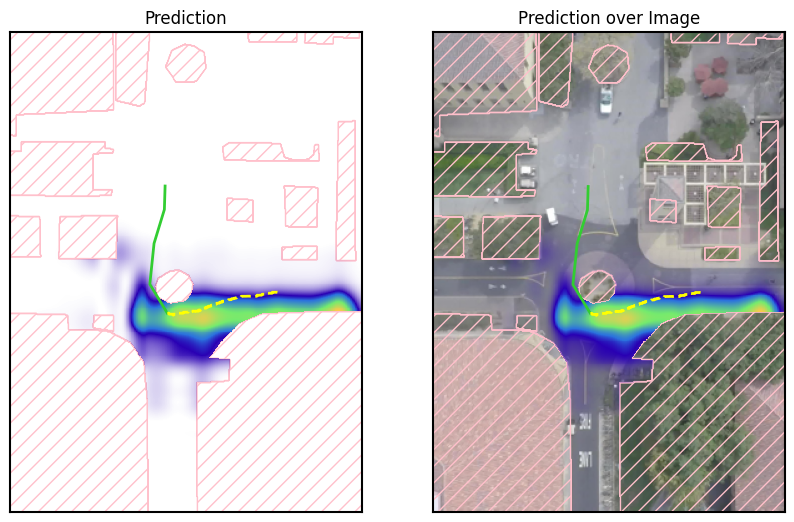

In [7]:
import matplotlib.pyplot as plt

test_dataset = sdd.load_dataset().test

# for _ in range(50):
# import numpy as np
# test_idx = np.random.randint(0, len(test_dataset))
test_idx = 35249
print(f"Test index: {test_idx}")

# returns the full future for the remaining trajectory
_, _, test_full_horizon = sdd.dataset.get_trajectories_prediction_full_horizon()

x,y_future = test_full_horizon[test_idx]

with torch.no_grad():
    x_t = torch.tensor(x, dtype=torch.float32).reshape(-1)
    distribution = spline_model(x_t.unsqueeze(0).to(device))
    densities = distribution.log_dens(mesh.to(device), with_indicator=True).exp().cpu().numpy()
    densities = densities.reshape(mesh_grid[0].shape).T

plt_extent = [0, img_extent[1], img_extent[3], 0]


fig, axs = plt.subplots(1, 2, figsize=(10, 10))
ax = axs[0]
plot_helper.plot_diverging(
    the_ax=ax,
    data=densities,
    valid=valid,
    border=border.T,
    img_extent=plt_extent,
    with_contour=True,
    with_valid=False,
    hatched=True,
    plot_borders_below=True,
    the_cmap=plot_helper.blue_red8_transparent,
)

scale = sdd.dataset.get_scale()

ax.plot(x[:,0], x[:,1], color="limegreen", linewidth=2.0)
ax.plot(y_future[:,0], y_future[:,1], color='yellow', linestyle='--', label='Test Y', linewidth=2.0)

ax.set_title(f"Prediction")

ax = axs[1]
ax.imshow(sdd.dataset.image)

plt_extent = [0, sdd.dataset.image.shape[1], sdd.dataset.image.shape[0], 0]

plot_helper.plot_diverging(
    the_ax=ax,
    data=densities,
    valid=valid,
    border=border.T,
    img_extent=plt_extent,
    with_contour=True,
    with_valid=False,
    hatched=True,
    plot_borders_below=True,
    the_cmap=plot_helper.blue_red8_transparent,
)

ax.set_title(f"Prediction over Image")
# add a black border to the image
# frame a bit thicker
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

ax.plot(x[:,0] / sdd.dataset.scale, x[:,1] / sdd.dataset.scale, color="limegreen", linewidth=2.0)
ax.plot(y_future[:,0] / sdd.dataset.scale, y_future[:,1] / sdd.dataset.scale, color='yellow', linestyle='--', label='Test Y', linewidth=2.0)

plt.show()

Sampling: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]

Sampling took 1.223 seconds on average


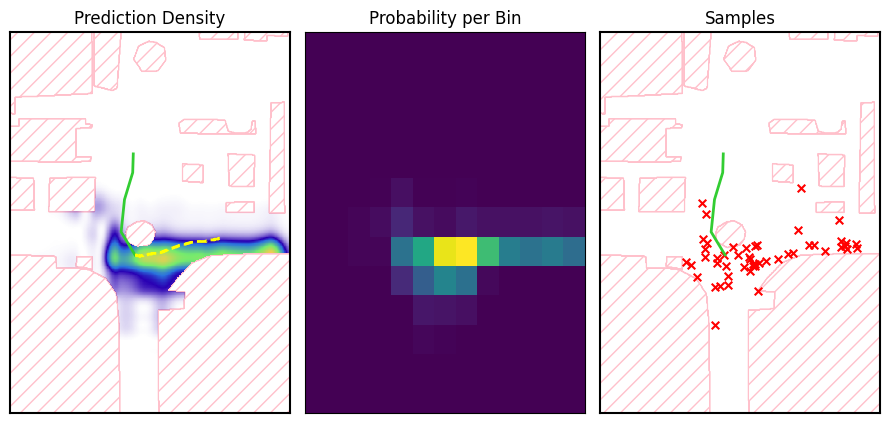

In [9]:
import time
from pal.distribution.sampling.inverse_transform import sample_spline_distribution
from tqdm import tqdm
# reload inverse_transform module
import importlib
import pal.distribution.sampling.inverse_transform as inverse_transform
importlib.reload(inverse_transform)
importlib.reload(spline)


n_samples = 50
torch.manual_seed(42)

fig, axs = plt.subplots(1, 3, figsize=(9, 6), sharex=True, sharey=True)
ax = axs[0]
plot_helper.plot_diverging(
    the_ax=ax,
    data=densities,
    valid=valid,
    border=border.T,
    img_extent=plt_extent,
    with_contour=True,
    with_valid=False,
    hatched=True,
    plot_borders_below=True,
    the_cmap=plot_helper.blue_red8_transparent,
)

scale = sdd.dataset.get_scale()

ax.plot(x[:,0] / sdd.dataset.scale, x[:,1] / sdd.dataset.scale, color="limegreen", linewidth=2.0)
ax.plot(y_future[:,0] / sdd.dataset.scale, y_future[:,1] / sdd.dataset.scale, color='yellow', linestyle='--', label='Test Y', linewidth=2.0)

ax.set_title(f"Prediction Density")

ax = axs[1]

ax.set_title(f"Probability per Bin")


def calc_pro_bins(i, w):
    return i / i.sum() * w

integrals = distribution.integrals_2dgrid.squeeze(0)

per_mixture = torch.vmap(calc_pro_bins)(integrals, distribution.mixture_weights.squeeze(0))
probabilities_per_bins = per_mixture.sum(dim=0)

ax.imshow(probabilities_per_bins.cpu().numpy().T, extent=plt_extent, origin='upper', aspect='auto')

axs[1].set_aspect(aspect=axs[0].get_aspect(), adjustable='box')

ax = axs[2]

points = []
times = []
for _ in tqdm(range(n_samples), desc="Sampling"):
    with torch.no_grad():
        time_start = time.time()
        point = sample_spline_distribution(distribution, device=device)
        time_end = time.time()
        times.append(time_end - time_start)
        points.append(point.cpu())
points = torch.stack(points).reshape(-1, 2).cpu().numpy()

print(f"Sampling took {sum(times) / len(times):.3f} seconds on average")

ax.set_title(f"Samples")
ax.scatter(points[:, 0] / sdd.dataset.scale, points[:, 1] / sdd.dataset.scale, color="red", s=30, marker='x', label='Samples')

plot_helper.plot_diverging(
    the_ax=ax,
    data=None,
    valid=valid,
    border=border.T,
    img_extent=plt_extent,
    with_contour=True,
    with_valid=False,
    hatched=True,
    plot_borders_below=True,
    the_cmap=plot_helper.blue_red8_transparent,
)

ax.plot(x[:,0] / sdd.dataset.scale, x[:,1] / sdd.dataset.scale, color="limegreen", linewidth=2.0)

axs[2].set_aspect(aspect=axs[0].get_aspect(), adjustable='box')

plt.tight_layout()

plt.show()

